In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pickle

from sl_model import SL512, DSODSL512
from sl_utils import PriorUtil
from ssd_utils import load_weights, calc_memory_usage

Using TensorFlow backend.


### Model

In [ ]:
model = DSODSL512(input_shape=(1536,1536,3))
image_size = model.image_size
prior_util = PriorUtil(model)
calc_memory_usage(model)

weights_path = './checkpoints/201806021007_dsodsl512_synthtext/weights.012.h5'
segment_threshold = 0.55; link_threshold = 0.45
load_weights(model, weights_path)

model memory usage    13.14 GB


### SynthText

In [3]:
from data_synthtext import GTUtility
file_name = 'gt_util_synthtext_seglink_xxs.pkl'
with open(file_name, 'rb') as f:
    gt_util = pickle.load(f)
#print(gt_util)

In [4]:
_, inputs, images, data = gt_util.sample_random_batch(batch_size=16, input_size=image_size)

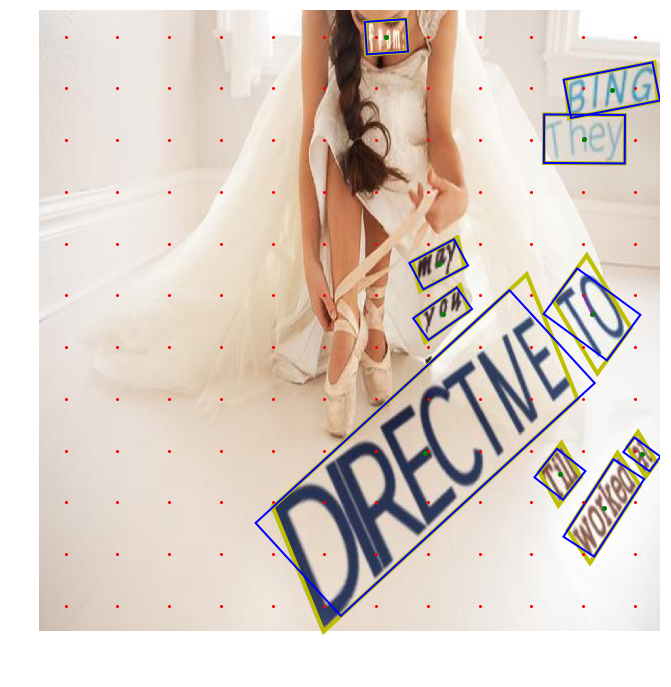

In [5]:
test_idx = 0
test_input = inputs[test_idx]
test_img = images[test_idx]
test_gt = data[test_idx]

plt.figure(figsize=[12]*2)
plt.axis('off')
plt.imshow(test_img)

prior_util.encode(test_gt, debug=False)
    
#for m_idx in [0,1,2,3]:
#for m_idx in range(len(prior_util.prior_maps)):
for m_idx in [4]:
    #prior_util.prior_maps[m_idx-1].plot_locations()
    prior_util.prior_maps[m_idx].plot_locations()
    #prior_util.prior_maps[m_idx].plot_boxes(range(0,200,40))
    #prior_util.plot_neighbors(m_idx, [0,20], cross_layer=False)
    #prior_util.plot_neighbors(m_idx, range(0,200,20), inter_layer=False)
    prior_util.plot_assignement(m_idx)

plt.show()

### Encoding/decoding

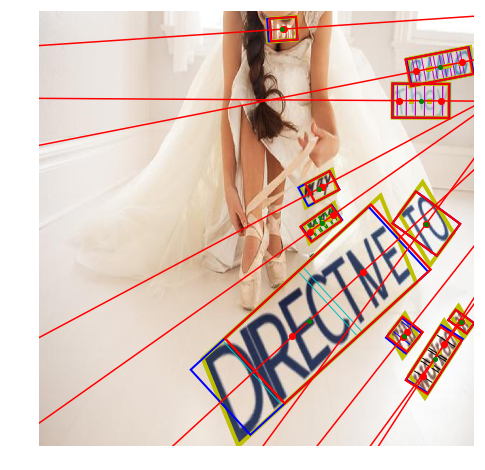

In [6]:
test_encoded_gt = prior_util.encode(test_gt)

dummy_output = np.copy(test_encoded_gt)
#dummy_output[:,2:4] += np.random.randn(*dummy_output[:,2:4].shape)*0.05

plt.figure(figsize=[8]*2)
ax = plt.gca()
plt.imshow(test_img)
res = prior_util.decode(dummy_output, debug=False, debug_combining=True)
#res = decode(prior_util, dummy_output, debug=False)
prior_util.plot_gt()
prior_util.plot_results(res)
plt.axis('off'); plt.xlim(0, image_size[1]); plt.ylim(image_size[0],0)
plt.show()

In [7]:
batch_size = 16
print('queue size %0.3f gb' % (inputs[0].nbytes*batch_size/(1024**3),))

queue size 0.422 gb


16/16 [==============================] - 7s 465ms/step


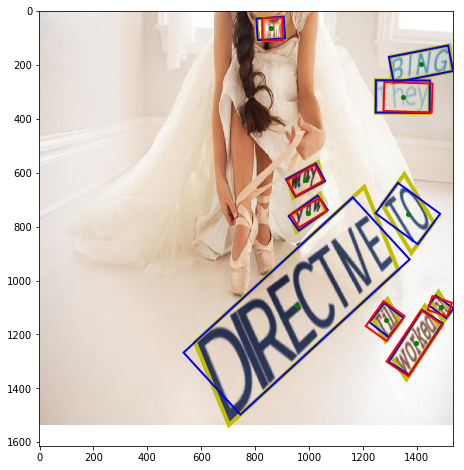

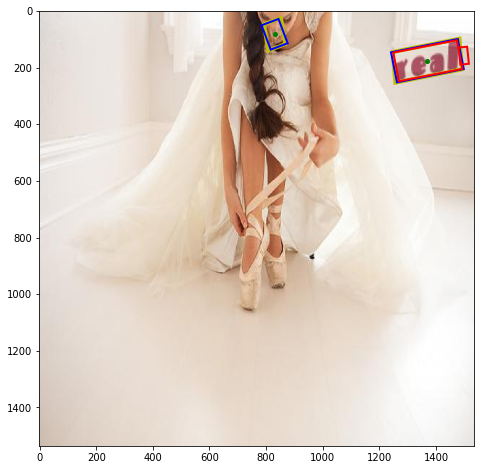

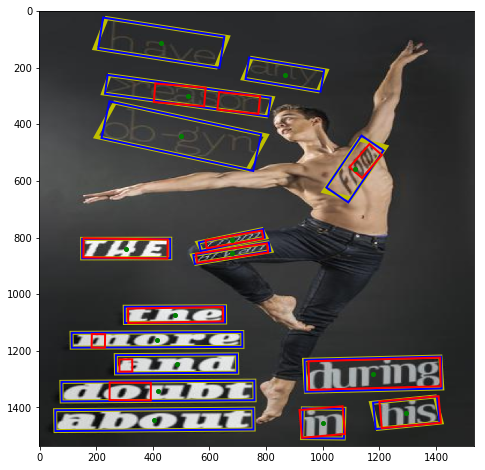

In [8]:
preds = model.predict(inputs, batch_size=1, verbose=1)

checkdir = os.path.split(weights_path)[0]

for fl in glob.glob('%s/result_*' % (checkdir,)):
    #os.remove(fl)
    pass

for i in range(3):
    plt.figure(figsize=[8]*2)
    plt.imshow(images[i])
    res = prior_util.decode(preds[i], segment_threshold, link_threshold)
    prior_util.encode(data[i])
    prior_util.plot_gt()
    prior_util.plot_results(res)
    #plt.savefig('%s/result_%03d.jpg' % (checkdir, i))
    plt.show()

### ICDAR2015 IST

In [9]:
from data_icdar2015ist import GTUtility
gt_util_test = GTUtility('data/ICDAR2015_IST/', test=True)
#print(gt_util_test)

16/16 [==============================] - 5s 299ms/step


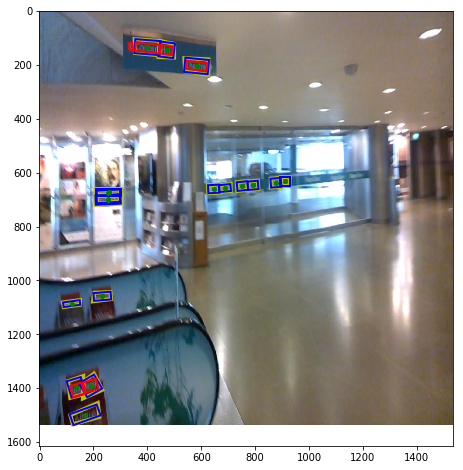

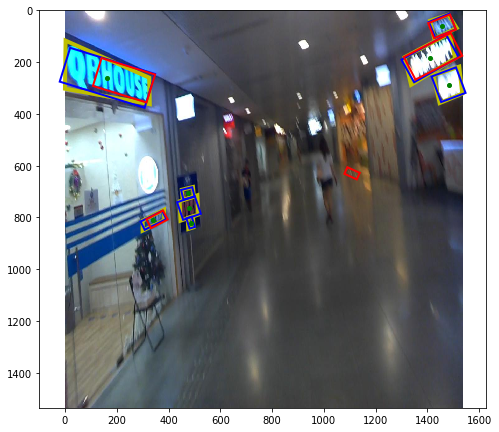

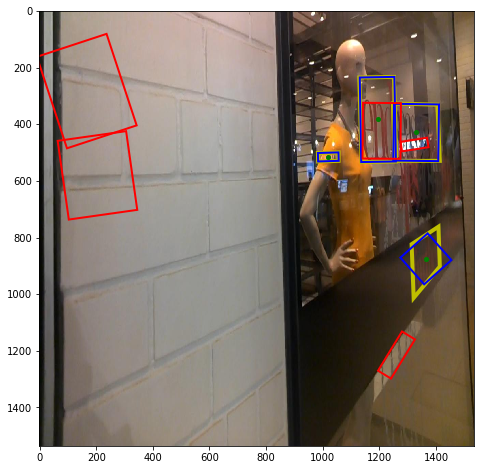

In [10]:
_, inputs, images, data = gt_util_test.sample_random_batch(batch_size=16, input_size=image_size)

preds = model.predict(inputs, batch_size=1, verbose=1)

checkdir = os.path.split(weights_path)[0]

for fl in glob.glob('%s/result_*' % (checkdir,)):
    #os.remove(fl)
    pass

for i in range(3):
    plt.figure(figsize=[8]*2)
    plt.imshow(images[i])
    res = prior_util.decode(preds[i], segment_threshold, link_threshold)
    prior_util.encode(data[i])
    prior_util.plot_gt()
    prior_util.plot_results(res)
    #plt.savefig('%s/result_%03d.jpg' % (checkdir, i))
    plt.show()